# Test of pearson residula on zebrafish data

Import the package and silence some warning information (mostly `is_categorical_dtype` warning from anndata)

In [20]:
import warnings

warnings.filterwarnings("ignore")

import dynamo as dyn
from dynamo.configuration import DKM
import numpy as np


this is like R's sessionInfo() which helps you to debug version related bugs if any. 

## Load data 

Dynamo comes with a few builtin sample datasets so you can familiarize with dynamo before analyzing your own dataset.
You can read your own data via `read`, `read_loom`, `read_h5ad`, `read_h5` (powered by the [anndata](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) package) or load_NASC_seq, etc. Here I just load the zebrafish sample data that comes with dynamo. This dataset has 4181 cells and 16940 genes. Its `.obs` attribute also included `condition`, `batch` information from the original study (you should also store those information to your `.obs` attribute which is essentially a Pandas Dataframe, see more at [anndata](https://anndata.readthedocs.io/en/latest/)). `Cluster`, `Cell_type`, umap coordinates that was originally analyzed with [Monocle 3](https://cole-trapnell-lab.github.io/monocle3/) are also provided. 

In [21]:
adata = dyn.sample_data.zebrafish()


|-----> Downloading data to ./data/zebrafish.h5ad


In [22]:
import scipy.sparse
from scipy import sparse
import anndata


def remove_rare_genes(counts, genes, minimum_detected_cells_per_gene):

    if type(counts) in [sparse.csr.csr_matrix, sparse.csc.csc_matrix]:

        # remove zero genes
        nonzero_genes_idx = np.array(counts.sum(axis=0)).flatten() > 0

        counts = counts[:, nonzero_genes_idx]
        genes = genes[nonzero_genes_idx]

        # count nonzero entries per gene
        nonzero_coords = counts.nonzero()
        n_nonzero = counts.count_nonzero()
        is_nonzero = sparse.csc_matrix((np.ones(n_nonzero), nonzero_coords))
        detected_cells_per_gene = np.array(is_nonzero.sum(axis=0)).flatten()

        keep_genes = detected_cells_per_gene >= minimum_detected_cells_per_gene
        counts_kept = counts[:, keep_genes]
        genes_kept = genes[keep_genes]

        print(
            "Of",
            len(detected_cells_per_gene),
            "total genes, returning",
            sum(keep_genes),
            "genes that are detected in %u or more cells."
            % (minimum_detected_cells_per_gene),
        )
        print("Output shape:", counts_kept.shape)

        return counts_kept, np.array(genes_kept)

    else:

        # remove zero genes
        nonzero_genes_idx = np.sum(counts, axis=0) > 0
        counts = counts[:, nonzero_genes_idx]
        genes = genes[nonzero_genes_idx]

        # remove genes that are detected in less then n cells
        nonzero = counts > 0
        cells_per_gene = np.sum(nonzero, axis=0)
        include_genes = cells_per_gene >= minimum_detected_cells_per_gene
        counts_kept = counts[:, include_genes]
        genes_kept = genes[include_genes]
        print(
            "Of",
            len(cells_per_gene),
            "total genes, returning",
            sum(include_genes),
            "genes that are detected in %u or more cells."
            % (minimum_detected_cells_per_gene),
        )
        print("Output shape:", counts_kept.shape)
        return counts_kept, genes_kept


def preprocess_adata_pearson_paper(adata):
    counts, genes, cells = adata.X, np.array(adata.var_names), adata.obs_names

    counts = counts.toarray()

    # remove low depth cells
    depths = np.array(np.sum(counts, axis=1)).flatten()
    minimum_depth = 500
    cells = cells[depths > minimum_depth]
    counts = counts[depths > minimum_depth, :]
    print(
        "Of",
        len(depths),
        "cells, returning",
        sum(depths > minimum_depth),
        "cells that have a depth larger than",
        minimum_depth,
    )
    print("New shape:", counts.shape)

    counts, genes = remove_rare_genes(counts, genes, minimum_detected_cells_per_gene=5)
    counts = sparse.csr_matrix(counts)
    res = anndata.AnnData(X=counts)
    return res



In [23]:
import statsmodels.api as sm
from datetime import datetime


def compute_marginals(counts):
    """compute depths per cell (ns) and relative expression fractions per gene (ps)"""
    ns = np.sum(counts, axis=1)
    ps = np.sum(counts, axis=0)
    ps = ps / np.sum(ps)
    return np.squeeze(np.array(ns)), np.squeeze(np.array(ps))


def monitor_progress(gene_id, n_genes, print_time_every=1000, print_dot_every=25):
    if np.mod(gene_id, print_time_every) == 0:
        print("")
        print(
            "##",
            datetime.now().time(),
            "##",
            gene_id,
            "of",
            n_genes,
            "genes fit",
            end="",
        )
    if np.mod(gene_id, print_dot_every) == 0:
        print(".", end="")


def fit_offsetmodel_w_statsmodel(counts, depths, name):
    """use statsmodel to fit offsetmodel (Eq. 3) and obtain beta0 (intercept) estimates, saving results to file"""
    n_cells = counts.shape[0]
    n_genes = counts.shape[1]

    ##np.ones: will fit intercept beta0
    X = np.ones((n_cells, 1))
    ##log(depths): will be used as offsets
    logdepths = np.log(depths)

    beta0 = np.zeros(n_genes) * np.nan
    for gene_id in range(n_genes):
        offsetmodel = sm.Poisson(counts[:, gene_id], X, offset=logdepths)
        result = offsetmodel.fit(disp=0)
        beta0[gene_id] = result.params

        monitor_progress(gene_id, n_genes)

    res = dict(beta0=beta0)
    # np.save('fit_results/fit_offsetmodel_w_statsmodel_%s' % (name),res)


In [24]:
adata = preprocess_adata_pearson_paper(adata)


In [25]:
import scanpy as sc


def pearson_residuals(counts, theta, clipping=True):
    """Computes analytical residuals for NB model with a fixed theta, clipping outlier residuals to sqrt(N)"""
    counts_sum0 = np.sum(counts, axis=0, keepdims=True)
    counts_sum1 = np.sum(counts, axis=1, keepdims=True)
    counts_sum = np.sum(counts)

    # get residuals
    mu = counts_sum1 @ counts_sum0 / counts_sum
    z = (counts - mu) / np.sqrt(mu + mu ** 2 / theta)

    # clip to sqrt(n)
    if clipping:
        n = counts.shape[0]
        z[z > np.sqrt(n)] = np.sqrt(n)
        z[z < -np.sqrt(n)] = -np.sqrt(n)

    return z


def pearson_residuals_PCA(adata, theta=100, n_comps=50):
    adata = adata.copy()
    counts = adata.X.toarray()
    return sc.pp.pca(pearson_residuals(counts, theta), random_state=42, n_comps=n_comps)



In [26]:
pca_reduced_counts = pearson_residuals_PCA(adata)
adata.obsm["X_pca_pearson"] = pca_reduced_counts


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
adata.obsm["X_pca_pearson"]

array([[-15.597142  ,  -6.3667483 ,  -2.144211  , ...,   0.6135125 ,
         -0.42440122,  -0.07755979],
       [-13.199008  ,  -9.480839  ,  -6.4491725 , ...,   1.1760699 ,
          0.28251767,  -0.39280787],
       [-25.472523  ,   1.0001048 ,  27.995993  , ...,  -0.5333733 ,
          2.693091  ,   0.36366162],
       ...,
       [ 10.02985   , -14.028355  , -12.073074  , ...,  -1.8847305 ,
         -2.2358758 ,  -3.1401749 ],
       [  8.808733  , -15.998152  , -11.24421   , ...,   1.3771492 ,
         -4.614617  ,   3.7940211 ],
       [ -5.928084  , -24.506561  , -24.752354  , ...,   2.0322068 ,
          6.9996734 ,  -1.9071083 ]], dtype=float32)

KeyError: 'Could not find key Cell_type in .var_names or .obs.columns.'

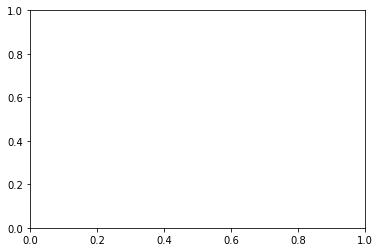

In [ ]:
sc.pl.embedding(adata, basis="X_pca_pearson", color=["Cell_type"])